In [238]:
import pandas as pd
import os


#Census data. See the data definition. 2000-2009 have different format compared to 2010-2014
file_dir = r'C:\Users\Noah\Desktop\python\census\data\\'

#read 2010-2014 county census data
df_cen = pd.read_csv('CC-EST2014-ALLDATA.csv',encoding='latin-1', dtype={'STATE':str, 'COUNTY':str})

#read 2000-2009 county census data (in 50 separate files)
df_cen2 = pd.DataFrame()
for filename in os.listdir(file_dir):
#    print(filename)
    tmp = pd.read_csv(file_dir+filename,encoding='latin-1', dtype={'STATE':str, 'COUNTY':str})    
    if df_cen2.empty:
        df_cen2 = tmp
    else:
        df_cen2 = df_cen2.append(tmp,ignore_index =True)


#county FIPS
df_cen['FIPS'] = df_cen['STATE']+df_cen['COUNTY']        
df_cen2['FIPS'] = df_cen2['STATE']+df_cen2['COUNTY']        
        
#Overlapping year definition to 2000-2009 dataset
year = 2010
for ii in range(3,8):
    df_cen.loc[df_cen['YEAR']==ii, 'YEAR'] = year
    year += 1        
#clean year
year = 2000
for ii in range(2,12):
    df_cen2.loc[df_cen2['YEAR']==ii, 'YEAR'] = year
    year += 1


#aggregate the population based on ethnicity
#df_cen['W']= df_cen['WA_MALE']+df_cen['WA_FEMALE']+df_cen['WAC_MALE']+df_cen['WAC_FEMALE']+df_cen['NHWA_MALE']+df_cen['NHWA_FEMALE']
#df_cen['B']= df_cen['BA_MALE']+df_cen['BA_FEMALE']+df_cen['BAC_MALE']+df_cen['BAC_FEMALE']+df_cen['NHBA_MALE']+df_cen['NHBA_FEMALE']
#df_cen['A']= df_cen['AA_MALE']+df_cen['AA_FEMALE']+df_cen['AAC_MALE']+df_cen['AAC_FEMALE']+df_cen['NHAA_MALE']+df_cen['NHAA_FEMALE']
df_cen['W']= df_cen['WA_MALE']+df_cen['WA_FEMALE']+df_cen['NHWA_MALE']+df_cen['NHWA_FEMALE']
df_cen['B']= df_cen['BA_MALE']+df_cen['BA_FEMALE']+df_cen['NHBA_MALE']+df_cen['NHBA_FEMALE']
df_cen['A']= df_cen['AA_MALE']+df_cen['AA_FEMALE']+df_cen['NHAA_MALE']+df_cen['NHAA_FEMALE']
df_cen['H']= df_cen['H_MALE']+df_cen['H_FEMALE']+df_cen['HTOM_MALE']+df_cen['HTOM_FEMALE']

df_cen2['W']=df_cen2['WA_MALE']+df_cen2['WA_FEMALE']+df_cen2['NHWA_MALE']+df_cen2['NHWA_FEMALE']
df_cen2['B']=df_cen2['BA_MALE']+df_cen2['BA_FEMALE']+df_cen2['NHBA_MALE']+df_cen2['NHBA_FEMALE']
df_cen2['A']=df_cen2['AA_MALE']+df_cen2['AA_FEMALE']+df_cen2['NHAA_MALE']+df_cen2['NHAA_FEMALE']
df_cen2['H']=df_cen2['H_MALE']+df_cen2['H_FEMALE']+df_cen2['HTOM_MALE']+df_cen2['HTOM_FEMALE']


#get the total population
df1 = df_cen[(df_cen['AGEGRP']==0) & (df_cen['YEAR']>2009)]
df2 = df_cen2[(df_cen2['AGEGRP']==99) & (df_cen2['YEAR']>1999)]

#aggregate
df = df1[['FIPS','YEAR','TOT_POP','W','B','A','H']]
dfc = df.append(df2[['FIPS','YEAR','TOT_POP','W','B','A','H']],ignore_index =True)


In [214]:
#read zillow county home price data
df_z = pd.read_csv('County_Zhvi_AllHomes.csv')
df_z['StateCodeFIPS'] = df_z.StateCodeFIPS.map("{:02}".format)
df_z['MunicipalCodeFIPS'] = df_z.MunicipalCodeFIPS.map("{:03}".format)
df_z['FIPS'] = df_z['StateCodeFIPS']+df_z['MunicipalCodeFIPS']
df_zpi = df_z[['FIPS','RegionName']]

#average out monthly value to annual value
for yr in range(2000,2015):
    yr = str(yr)
    tmp_list = []
    for header in list(df_z.columns.values):
        if yr == (header.split('-')[0]):            
            tmp_list.append((header))
    df_zpi[int(yr)] = df_z[tmp_list].mean(axis=1)

#Stack and clean up
df = df_zpi.set_index(['FIPS','RegionName'])
df1 = df.stack()
dfz = df1.reset_index()
dfz.rename(columns={'FIPS':'FIPS','RegionName':'RegionName','level_2':'YEAR', 0:'HPI'}, inplace = True)

C:\Users\Noah\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


['01003' '01007' '01027' ..., '55139' '56021' '56025']


C:\Users\Noah\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


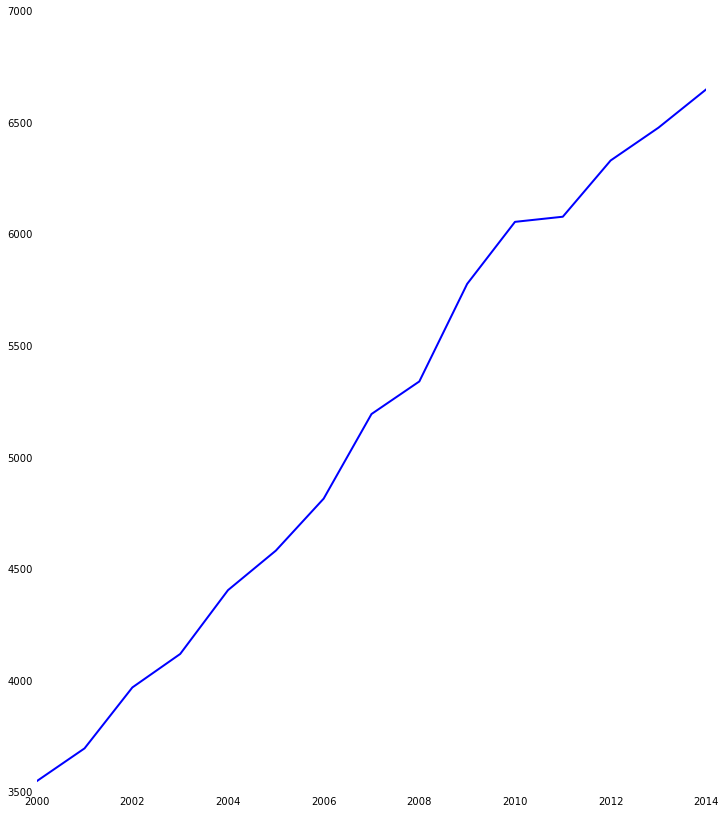

In [258]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.mlab import csv2rec
from matplotlib.cbook import get_sample_data
#merge
df = pd.merge(dfc,dfz, on=['FIPS','YEAR'])
df.sort(columns=['FIPS','YEAR'],inplace=True)
df.reset_index(drop=True,inplace=True)

# You typically want your plot to be ~1.33x wider than tall. This plot
# is a rare exception because of the number of lines being plotted on it.
# Common sizes: (10, 7.5) and (12, 9)
fig, ax = plt.subplots(1, 1, figsize=(12, 14))

# Remove the plot frame lines. They are unnecessary here.
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Ensure that the axis ticks only show up on the bottom and left of the plot.
# Ticks on the right and top of the plot are generally unnecessary.
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# Limit the range of the plot to only where the data is.
# Avoid unnecessary whitespace.
#plt.xlim(1999.5, 2014.1)
#plt.ylim(-0.25, 100000)


# Make sure your axis ticks are large enough to be easily read.
# You don't want your viewers squinting to read your plot.
#plt.xticks(range(2000, 2014, 2), fontsize=14)
#plt.yticks(range(0, 100000, 10000), ['{0}'.format(x)
#                              for x in range(0, 100000, 10000)], fontsize=14)

# Provide tick lines across the plot to help your viewers trace along
# the axis ticks. Make sure that the lines are light and small so they
# don't obscure the primary data lines.
#for y in range(10, 91, 10):
#    plt.plot(range(1969, 2012), [y] * len(range(1969, 2012)), '--',
#             lw=0.5, color='black', alpha=0.3)
    
# Remove the tick marks; they are unnecessary with the tick lines we just
# plotted.
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='on', left='off', right='off', labelleft='on')

#print(df.head())

#line = plt.plot(df[df['FIPS']=='01003'].YEAR,
#                df[df['FIPS']=='01003'].W,
#                lw=2.)
line = plt.plot(df[df['FIPS']=='55139'].YEAR,
                df[df['FIPS']=='55139'].B,
                lw=2.)
#                color=color_sequence[rank])








print(df['FIPS'].unique())

In [259]:
df[]

,FIPS,YEAR,TOT_POP,W,B,A,H,RegionName,HPI
0,01003,2000,141342,246016,29082,1088,2531,Baldwin,132858.333333
1,01003,2001,144875,251784,29576,1209,2948,Baldwin,140291.666667
2,01003,2002,147957,256907,29895,1338,3327,Baldwin,142491.666667
3,01003,2003,151509,262780,30295,1423,3744,Baldwin,149216.666667
4,01003,2004,156266,270607,30780,1857,4226,Baldwin,161133.333333
5,01003,2005,162183,280647,31490,1948,4879,Baldwin,186825.000000
6,01003,2006,168121,290548,32140,2047,5644,Baldwin,212016.666667
7,01003,2007,172404,297468,32741,2228,6325,Baldwin,204541.666667
8,01003,2008,175827,302471,33130,2429,7071,Baldwin,186441.666667
9,01003,2009,179406,307799,33722,2639,7762,Baldwin,166716.666667
